# Diabetic Retinopathy model

This interactive notebook will create a step-by-step self-learning convolutional neural network (CNN) model that classifies retina photographs into one of the five classes that equal the progression of retinopathy in the eye of the patient. 

You can run and tweak the code interactively in within this notebook.
To make sure the code is executed optimally, please select the GPU runtime option by going to runtime (in the top menu) > change runtime type > GPU at hardware acceleration. 

You can run the code in each distinct cell by either clicking the play button on the top left side of each cell, or by pressing shift+enter when a cell is highlighted. The highlight will then automatically move one slot down to the next cell.

In [1]:
import gc; gc.collect()

0

In [0]:
#Import numerical algebra and data analysis libraries
import numpy as np
import pandas as pd

The images and labels are available original formats at: https://drive.google.com/drive/folders/1ks-xI5ZOnXrFTGmSKEKAOiRQnF-pgHir 
The vectorized version of the images and labels are available at: https://drive.google.com/open?id=18piToTIqxvis8CwFu8Fjv3vgm4-qnCnC and https://drive.google.com/open?id=18piToTIqxvis8CwFu8Fjv3vgm4-qnCnC respectively. 

The following cells allow for the notebook to access the dataset that is stored in your google drive account. 

In [29]:
# Install a Drive FUSE wrapper: https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpuvxvcnye/pubring.gpg' created
gpg: /tmp/tmpuvxvcnye/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [31]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [32]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
Files in Drive:
architecture.json		Network.structuredefinition.xml
classification of outcomes.odt	Power questions with sentiment analysis app.odt
Code				Progress Report.docx.odt
Colab Notebooks			resourcemodel.docx
Demo				Results.ods
Drafts				Samenvattingen
hdf5.odt			Search table.ods
Home Coming Days		self made.PNG
images				testing performance time.odt
inception training.PNG		Transfer learning.odt
MI Career.odt			Voorbeelden
modelbaseline.json


In [33]:
#Test list directory
!ls drive/Colab\ Notebooks

bcancerdata.csv		      logs
BCancer.ipynb		      makesample.py
imlabel_test.npy	      Retinopathy
immatrix_test.npy	      retinopathy_inception.h5
inception_imlabel_small.npy   retinopathy_inception_weights.h5
inception_imlabel_test.npy    retinopathy_model.h5
inception_imlabel_val.npy     retinopathy_vggnet16.h5
inception_immatrix_small.npy  sample
inception_immatrix_test.npy   test_labels.csv
inception_immatrix_val.npy    train_labels.csv
labels.csv		      val_labels.csv


In [0]:
#Load the label csv datafile
trainLabels = pd.read_csv("drive/Colab Notebooks/train_labels.csv")
testLabels = pd.read_csv('drive/Colab Notebooks/test_labels.csv')
valLabels = pd.read_csv('drive/Colab Notebooks/val_labels.csv')

In [29]:
#Frequency of each label class in the dataset
valLabels.level.value_counts(True).to_frame(name='count').T

0      2     1      4      3
count  0.749  0.138  0.07  0.026  0.017

In [12]:
#Path manipulation library
import os

listing = os.listdir("drive/Colab Notebooks/sample/") 

#Remove the labels file from the count
listing.remove("trainLabels.csv")

#List number of training images
np.size(listing)

2000

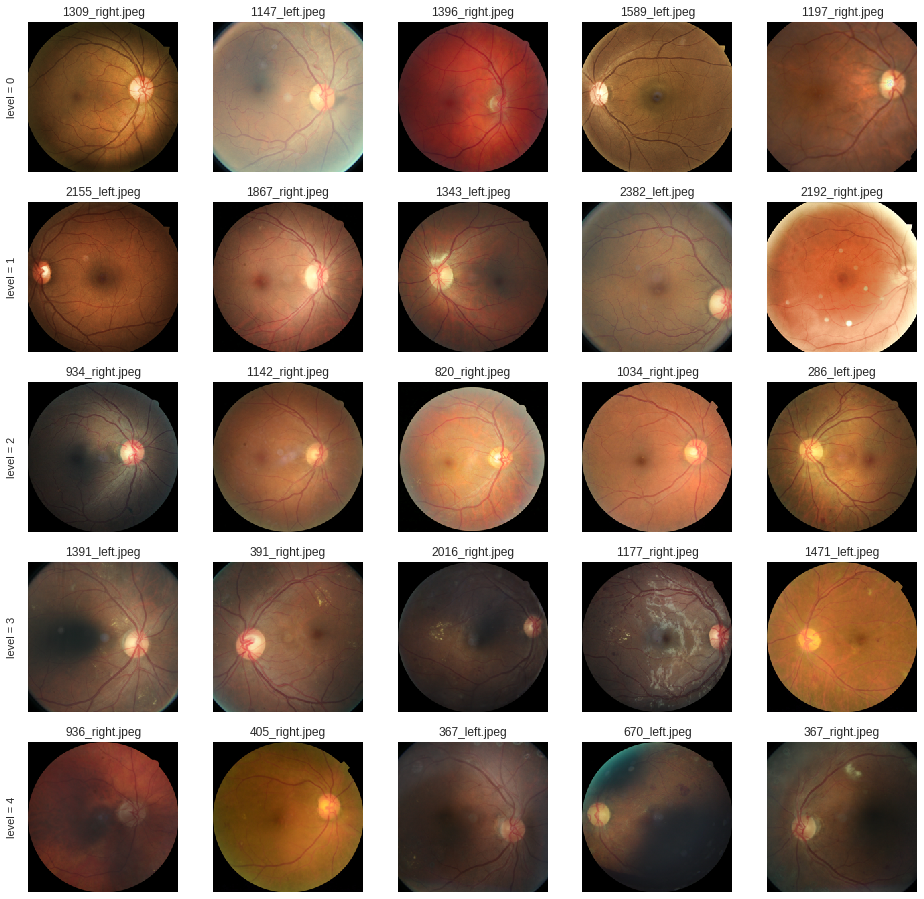

In [32]:
#Display 5 randomly sampled images for every severity level
import matplotlib.pyplot as plt
#Python imaging library
import PIL

#Create a function to convert images to arrays
def img_to_array(img):
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255

#Calculate thumbnail size with a constant aspect ratio 
def calc_thumbnail_size(img):
    width, length = img.size
    ratio = width / length

    # for some reason, if it's exactly 224, then thumnailed image is 223
    dim = 224 + 1          # output dim
    if ratio > 1:
        size = (dim * ratio, dim)
    else:
        size = (dim, dim / ratio)
    return size

#Crop to desired dimension size
def calc_crop_coords(img):
    dim = 224
    width, length = img.size
    left = 0
    right = width
    bottom = length
    top = 0
    if width > dim:
        delta = (width - dim) / 2
        left = delta
        right = width - delta
    if length > dim:
        delta = (length - dim) / 2
        top = delta
        bottom = length - delta
    return (left, top, right, bottom)

#Trim the black margin created by PIL
def trim(im):
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -20)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

#Crop the image
def preprocess(img):
    img = trim(img)
    tsize = calc_thumbnail_size(img)
    img.thumbnail(tsize)
    crop_coords = calc_crop_coords(img)
    img = img.crop(crop_coords)
    return img

imgs_with_label = []
n_samples = 5
for i in range(5):
    _vals = trainLabels.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join('drive/Colab Notebooks/sample/', v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
    im = PIL.Image.open(img)
    im = preprocess(im)
    ax = axes[k]
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))

In [8]:
#Install the keras deep learning library
!pip install keras

In [14]:
#Import deep learning library
import keras

#Import transfer learning model and image preprocessing modules
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


The Following section is only required if you have not downloaded the vectorised data and wish to convert the original data yourself. 
This can take up to one hour. 

In [0]:
#Python image library that vectorises images
from PIL import Image

In [0]:
#input image dimensions limited to input for VGGNet model later on
img_rows, img_cols = 224, 224

#Vectorise images 
immatrix = []
imlabel = []

for file in listing:
    base = os.path.basename("drive/Colab Notebooks/sample/" + file)
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open("drive/Colab Notebooks/sample/" + file)
    img = im.resize((img_rows,img_cols))
    immatrix.append(np.array(img))

In [0]:
#Cast vectors to numpy arrays
immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)

In [0]:
#Save created immatrix, imlabel matrices for later use
np.save('drive/Colab Notebooks/imlabel' ,imlabel)
np.save('drive/Colab Notebooks/immatrix',immatrix)

# Continue here if you skipped the above part

In [1]:
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [0]:
X_train = np.load('drive/Colab Notebooks/immatrix.npy')
y_train = np.load('drive/Colab Notebooks/imlabel.npy')

#Standardise 
X_train = X_train.astype('float32') / 255.


#Normalise X_train.astype('float32') X_train = np.array([((X_train[i] - X_train[i].mean())/X_train[i].std()) for i in range(len(X_train))])

#y_train = np_utils.to_categorical(y_train, 5)

In [2]:
#---------------------------------
X_test = np.load('drive/Colab Notebooks/immatrix_test.npy')
y_test = np.load('drive/Colab Notebooks/imlabel_test.npy')

# Standardise 
X_test = X_test.astype('float32') / 255.

#Normalise X_test.astype('float32') X_test = np.array([((X_test[i] - X_test[i].mean())/X_test[i].std()) for i in range(len(X_test))])

y_test = np_utils.to_categorical(y_test, 5)

FileNotFoundError: ignored

In [9]:
y_test.shape

(1999, 5)

In [0]:
#----------------------
X_val = np.load('drive/Colab Notebooks/immatrix_val.npy')
y_val = np.load('drive/Colab Notebooks/imlabel_val.npy')

#Standardise X_val = X_val.astype('float32') / 255.

#Normalise
X_val.astype('float32')
X_val = np.array([((X_val[i] - X_val[i].mean())/X_val[i].std()) for i in range(len(X_val))])

y_val = np_utils.to_categorical(y_val, 5)

In [12]:
print('Shape of X_train:',X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test:',X_test.shape)
print('Shape of y_train:', y_test.shape)

print('Shape of X_val:',X_val.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (9999, 224, 224, 3)
Shape of y_train: (9999, 5)
Shape of X_test: (1999, 224, 224, 3)
Shape of y_train: (1999, 5)
Shape of X_val: (999, 224, 224, 3)
Shape of y_val: (999, 5)


In [0]:
"""
Model without Transfer Learning
This model uses the most straightforward implementation of a CNN.
"""

#batch_size to train
batch_size = 64
# number of output classes
units = 5
# number of epochs to train
epochs = 10
# size of pooling area for max pooling
pool_size = 3
# convolution kernel size
kernel_size = 3

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (kernel_size, kernel_size),
                 activation='relu',
                 input_shape=(299, 299, 3)))
model.add(Conv2D(64, (kernel_size, kernel_size),
                 activation='relu'))
model.add(MaxPooling2D((pool_size, pool_size)))

#Adding the classifier
model.add(Flatten())
model.add(Dropout(0.5)) #Prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(units, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=["accuracy"])

#Log the network architecture
tensorboard = TensorBoard(log_dir='drive/Colab Notebooks/logs')

In [86]:
#Show the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 297, 297, 32)      896       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 295, 295, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 614656)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 614656)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                19669024  
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 165       
Total para

In [87]:
#Time the fitting duration
%%time 

#Validate every epoch on the validation data
history = model.fit([X_train], [y_train], epochs=epochs, 
                    batch_size=batch_size,
                    validation_data = (X_val, y_val),
                    callbacks=[tensorboard])

Train on 4999 samples, validate on 1000 samples
Epoch 1/10
4999/4999 [==============================] - 77s 15ms/step - loss: 1.7433 - acc: 0.7217 - val_loss: 0.8575 - val_acc: 0.7490
Epoch 2/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.8699 - acc: 0.7291 - val_loss: 0.8394 - val_acc: 0.7490
Epoch 3/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.8595 - acc: 0.7291 - val_loss: 0.8715 - val_acc: 0.7490
Epoch 4/10
3840/4999 [======================>.......] - ETA: 16s - loss: 0.8510 - acc: 0.7286

4999/4999 [==============================] - 76s 15ms/step - loss: 0.8534 - acc: 0.7291 - val_loss: 0.8489 - val_acc: 0.7490
Epoch 5/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.8393 - acc: 0.7289 - val_loss: 0.8547 - val_acc: 0.7490
Epoch 6/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.8283 - acc: 0.7295 - val_loss: 0.8703 - val_acc: 0.7490
Epoch 7/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.8237 - acc: 0.7299 - val_loss: 0.8567 - val_acc: 0.7480
Epoch 8/10
1280/4999 [======>.......................] - ETA: 52s - loss: 0.8278 - acc: 0.7133

4999/4999 [==============================] - 76s 15ms/step - loss: 0.8085 - acc: 0.7307 - val_loss: 0.8632 - val_acc: 0.7470
Epoch 9/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.7910 - acc: 0.7337 - val_loss: 0.8841 - val_acc: 0.7500
Epoch 10/10
4999/4999 [==============================] - 76s 15ms/step - loss: 0.7742 - acc: 0.7337 - val_loss: 0.8904 - val_acc: 0.7470
CPU times: user 3min 15s, sys: 5min 17s, total: 8min 32s
Wall time: 13min 1s


In [89]:
model.evaluate(X_test, y_test)

ValueError: ignored

In [50]:
model.evaluate(X_test, y_test)

1999/1999 [==============================] - 8s 4ms/step


[0.8106688202590332, 0.7518759379988017]

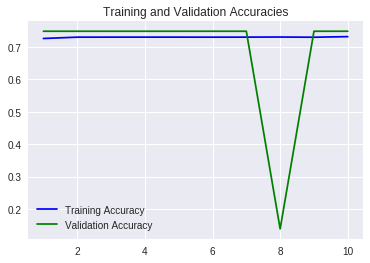

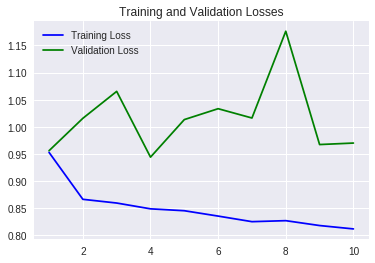

In [16]:
#Plot the accuracy and losses of the model
import matplotlib.pyplot as plt
import seaborn as sns; sns.set
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.legend()

In [0]:
#Save architecture, weights and biasses in a hierarchical data format
model.save('drive/Colab Notebooks/retinopathy_model.h5')

In [0]:
#Classify the test set images
Y_pred = model.predict(X_test)

In [19]:
#Ouput will be represented as probabilities of belonging to a specific class due to the softmax output layer
Y_pred[0:5]

array([[0.71376157, 0.05603939, 0.16583689, 0.03718737, 0.02717472],
       [0.8273321 , 0.03536193, 0.11601446, 0.01271013, 0.00858144],
       [0.8117226 , 0.07294914, 0.10174987, 0.00458708, 0.00899136],
       [0.79471135, 0.0796418 , 0.11415708, 0.0022158 , 0.00927402],
       [0.68411213, 0.08968725, 0.1762231 , 0.02752059, 0.02245693]],
      dtype=float32)

The accuracy seems to be stuck at 75% with a simple model. This model may be too generic when only having 2000 training images.

In [2]:
#Using TL - VGG16 pre-trained model on imagenet, see: https://arxiv.org/abs/1409.1556
from keras.applications.vgg16 import VGG16

vgg16_model = VGG16(weights="imagenet", include_top=True)
 
vgg16_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
#VGG16
from keras.models import Model

#Remove the top layer of the model
base_model = Model(inputs=vgg16_model.input, 
                   outputs=vgg16_model.get_layer("block5_pool").output) 

In [0]:
from keras.layers import Dense, Dropout, Reshape

#Attach a new top layer with a final layer for a 5 class multiclassification output
base_out = base_model.output
base_out = Reshape((25088,))(base_out)
top_fc1 = Dense(32, activation="relu")(base_out)
top_fc1 = Dropout(0.5)(top_fc1)
# output layer: (None, 5)
top_preds = Dense(5, activation="softmax")(top_fc1)

In [0]:
# Freeze weights until the last but one convolution layer (block4_pool) to stop the entire model from updating all the weights 
for layer in base_model.layers[0:14]:
    layer.trainable = False

In [19]:
#Create the hybrid model
model2 = Model(inputs=base_model.input, outputs=top_preds)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard

#checkpoint = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

#Log the model accuracy, graph and losses
tensorboard = TensorBoard(log_dir='drive/Colab Notebooks/logs')

Same classifier part but 4 mil less params due to the non-trainable con2d layers

In [0]:
model2.compile(optimizer='adam', loss="categorical_crossentropy",
              metrics=["accuracy"])

In [35]:
%%time 

history = model2.fit([X_train], [y_train], epochs=10, 
                    batch_size=64, validation_data=(X_val, y_val), 
                    callbacks=[tensorboard])

Train on 9999 samples, validate on 999 samples
Epoch 1/10
9999/9999 [==============================] - 132s 13ms/step - loss: 1.0280 - acc: 0.7111 - val_loss: 0.9012 - val_acc: 0.7487
Epoch 2/10
9999/9999 [==============================] - 121s 12ms/step - loss: 0.9526 - acc: 0.7306 - val_loss: 0.8517 - val_acc: 0.7487
Epoch 3/10
5184/9999 [==============>...............] - ETA: 53s - loss: 0.9575 - acc: 0.7224

9999/9999 [==============================] - 121s 12ms/step - loss: 0.9366 - acc: 0.7306 - val_loss: 0.8749 - val_acc: 0.7487
Epoch 4/10
9999/9999 [==============================] - 121s 12ms/step - loss: 0.9145 - acc: 0.7306 - val_loss: 0.8639 - val_acc: 0.7487
Epoch 5/10
9999/9999 [==============================] - 121s 12ms/step - loss: 0.9016 - acc: 0.7306 - val_loss: 0.8568 - val_acc: 0.7487
Epoch 6/10
 320/9999 [..............................] - ETA: 1:47 - loss: 0.9517 - acc: 0.6844

9999/9999 [==============================] - 121s 12ms/step - loss: 0.8760 - acc: 0.7306 - val_loss: 0.8552 - val_acc: 0.7487
Epoch 7/10
9999/9999 [==============================] - 121s 12ms/step - loss: 0.8655 - acc: 0.7305 - val_loss: 0.8616 - val_acc: 0.7487
Epoch 8/10
9408/9999 [===========================>..] - ETA: 6s - loss: 0.8564 - acc: 0.7283

9999/9999 [==============================] - 121s 12ms/step - loss: 0.8528 - acc: 0.7306 - val_loss: 0.8646 - val_acc: 0.7487
Epoch 9/10
9999/9999 [==============================] - 121s 12ms/step - loss: 0.8407 - acc: 0.7301 - val_loss: 0.8626 - val_acc: 0.7487
Epoch 10/10
9999/9999 [==============================] - 121s 12ms/step - loss: 0.8317 - acc: 0.7309 - val_loss: 0.9159 - val_acc: 0.7487
CPU times: user 4min 45s, sys: 1min 58s, total: 6min 43s
Wall time: 20min 31s


In [0]:
#Save the model architecture and weight and bias layers as a hdf5 file
model2.save('drive/Colab Notebooks/retinopathy_vggnet16.h5')

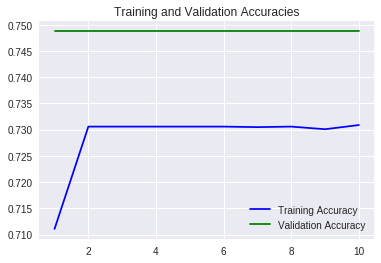

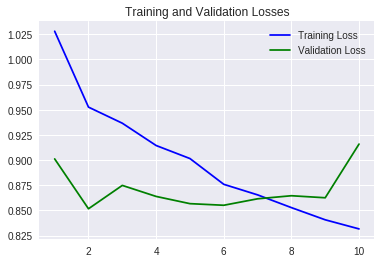

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Inception Model

In [7]:
import numpy as np
from keras.utils import np_utils

X_val = np.load('drive/Colab Notebooks/inception_immatrix_val.npy')
y_val = np.load('drive/Colab Notebooks/inception_imlabel_val.npy')

#Standardise 
X_val = X_val.astype('float32') / 255.


#Normalise X_train.astype('float32') X_train = np.array([((X_train[i] - X_train[i].mean())/X_train[i].std()) for i in range(len(X_train))])

y_val = np_utils.to_categorical(y_val, 5)

Using TensorFlow backend.


In [0]:
X_test = np.load('drive/Colab Notebooks/inception_immatrix_test.npy')
y_test = np.load('drive/Colab Notebooks/inception_imlabel_test.npy')

#Standardise 
X_test = X_test.astype('float32') / 255.


#Normalise X_train.astype('float32') X_train = np.array([((X_train[i] - X_train[i].mean())/X_train[i].std()) for i in range(len(X_train))])

y_test = np_utils.to_categorical(y_test, 5)

In [0]:
X_train = np.load('drive/Colab Notebooks/inception_immatrix_small.npy')
y_train = np.load('drive/Colab Notebooks/inception_imlabel_small.npy')

#Standardise 
X_train = X_train.astype('float32') / 255.


#Normalise X_train.astype('float32') X_train = np.array([((X_train[i] - X_train[i].mean())/X_train[i].std()) for i in range(len(X_train))])

y_train = np_utils.to_categorical(y_train, 5)

In [10]:
X_train.shape

(4999, 299, 299, 3)

In [14]:
y_val.shape

(1000, 5)

In [15]:
y_train.shape

(4999, 5)

In [16]:
import gc; gc.collect()

118

In [17]:
from keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(weights="imagenet", include_top=False)
 
inception_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________


activation_84 (Activation)      (None, None, None, 3 0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, None, None, 1 576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, None, None, 3 0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, None, None, 7 0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 7 0           activation_83[0][0]              
         

In [0]:
#Inception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard


base_out = inception_model.output
base_out = GlobalAveragePooling2D()(base_out)

top_fc1 = Dense(32, activation="relu")(base_out)
top_fc1 = Dropout(0.5)(top_fc1)

top_preds = Dense(5, activation="softmax")(top_fc1)

incmodel = Model(inputs=inception_model.input, outputs=top_preds)

for layer in inception_model.layers:
  layer.trainable = False
  
incmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
tensorboard = TensorBoard(log_dir='drive/Colab Notebooks/logs')

In [19]:
incmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (


batch_normalization_92 (BatchNo (None, None, None, 3 1152        conv2d_92[0][0]                  
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, None, None, 3 1152        conv2d_93[0][0]                  
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 1 393216      average_pooling2d_9[0][0]        
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, None, None, 3 960         conv2d_86[0][0]                  
__________________________________________________________________________________________________
activation_88 (Activation)      (None, None, None, 3 0           batch_normalization_88[0][0]     
__________________________________________________________________________________________________
activatio

In [20]:
%%time

history = incmodel.fit([X_train], [y_train], epochs=10, 
             batch_size=64, 
             validation_data=(X_val, y_val), 
             callbacks=[tensorboard])

Train on 4999 samples, validate on 1000 samples
Epoch 1/10
4999/4999 [==============================] - 73s 15ms/step - loss: 1.0229 - acc: 0.6945 - val_loss: 0.8853 - val_acc: 0.7490
Epoch 2/10
4999/4999 [==============================] - 67s 13ms/step - loss: 0.9417 - acc: 0.7241 - val_loss: 0.8372 - val_acc: 0.7490
Epoch 3/10
4999/4999 [==============================] - 67s 13ms/step - loss: 0.9007 - acc: 0.7291 - val_loss: 0.8355 - val_acc: 0.7490
Epoch 4/10
3840/4999 [======================>.......] - ETA: 12s - loss: 0.8807 - acc: 0.7302

4999/4999 [==============================] - 67s 13ms/step - loss: 0.8799 - acc: 0.7291 - val_loss: 0.8256 - val_acc: 0.7490
Epoch 5/10
4999/4999 [==============================] - 67s 13ms/step - loss: 0.8683 - acc: 0.7291 - val_loss: 0.8253 - val_acc: 0.7490
Epoch 6/10
4999/4999 [==============================] - 67s 13ms/step - loss: 0.8568 - acc: 0.7291 - val_loss: 0.8262 - val_acc: 0.7490
Epoch 7/10
4999/4999 [==============================] - 67s 13ms/step - loss: 0.8588 - acc: 0.7291 - val_loss: 0.8323 - val_acc: 0.7490
Epoch 8/10
1280/4999 [======>.......................] - ETA: 40s - loss: 0.8417 - acc: 0.7344

4999/4999 [==============================] - 67s 13ms/step - loss: 0.8447 - acc: 0.7291 - val_loss: 0.8205 - val_acc: 0.7490
Epoch 9/10
4999/4999 [==============================] - 67s 13ms/step - loss: 0.8527 - acc: 0.7291 - val_loss: 0.8333 - val_acc: 0.7490
Epoch 10/10
4999/4999 [==============================] - 66s 13ms/step - loss: 0.8277 - acc: 0.7291 - val_loss: 0.8279 - val_acc: 0.7490
CPU times: user 5min 5s, sys: 1min 52s, total: 6min 58s
Wall time: 11min 45s


In [0]:
incmodel.save('drive/Colab Notebooks/retinopathy_inception.h5')

In [0]:
incmodel.save_weights('drive/Colab Notebooks/retinopathy_inception_weights.h5')

In [23]:
score = incmodel.evaluate(X_test, y_test)

print("Model Loss:", score[0])
print("Model accuracy", score[1])

2000/2000 [==============================] - 30s 15ms/step
Model Loss: 0.7930341789722443
Model accuracy 0.752


## Time to Give the models a go at the test set

In [0]:
from keras.models import load_model

model = load_model('drive/Colab Notebooks/retinopathy_model.h5')
model1 = load_model('drive/Colab Notebooks/retinopathy_inception.h5')
model2 = load_model('drive/Colab Notebooks/retinopathy_vggnet16.h5')

In [10]:
import numpy as np 

X_test = np.load('drive/Colab Notebooks/immatrix_test.npy')
y_test = np.load('drive/Colab Notebooks/imlabel_test.npy')

#Standardise 
X_test = X_test.astype('float32') / 255.


#Normalise X_train.astype('float32') X_train = np.array([((X_train[i] - X_train[i].mean())/X_train[i].std()) for i in range(len(X_train))])

y_test = np_utils.to_categorical(y_test, 5)

FileNotFoundError: ignored

In [8]:
score = model.evaluate(X_test, y_test)

print("Model Loss:", score[0])
print("Model accuracy", score[1])

NameError: ignored

In [47]:
score1 = model1.evaluate(X_test, y_test)

print("Model Loss:", score1[0])
print("Model accuracy", score1[1])

1999/1999 [==============================] - 6s 3ms/step
Model Loss: 0.9260849184158625
Model accuracy 0.741370685432123


In [45]:
score2 = model2.evaluate(X_test, y_test)

print("Model Loss:", score2[0])
print("Model accuracy", score2[1])

1999/1999 [==============================] - 24s 12ms/step
Model Loss: 0.7797671398292367
Model accuracy 0.7518759379988017


In [0]:
y_scores = model.predict_classes(X_test)
y_scores1 = model1.predict_classes(X_test)
y_scores2 = model2.predict_classes(X_test)

In [25]:
!pip install pandas_ml

    100% |████████████████████████████████| 81kB 2.3MB/s 
  Running setup.py bdist_wheel for pandas-ml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/4b/b0/88/51fb7203a0f81becae3e92d5bf9fee0460375e5408e67a7dc3
Successfully built pandas-ml
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
y_test = np.load('drive/Colab Notebooks/imlabel_test.npy')

In [30]:
#Dumb baseline
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix (y_test, np.zeros(2000))
cm.print_stats()

/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:259: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TN) / self.NegativeTest)
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:304: RuntimeWarning: invalid value encountered in true_divide
  (self.TN + self.FP) * (self.TN + self.FN)))
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:339: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.FNR) / self.TNR)
/usr/local/lib/python3

Confusion Matrix:

Predicted   0.0  1.0  2.0  3.0  4.0  __all__
Actual                                      
0.0        1504    0    0    0    0     1504
1.0         148    0    0    0    0      148
2.0         280    0    0    0    0      280
3.0          39    0    0    0    0       39
4.0          29    0    0    0    0       29
__all__    2000    0    0    0    0     2000


Overall Statistics:

Accuracy: 0.752
95% CI: (0.7324625681715994, 0.7707959095838559)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                     0.0    1.0   2.0     3.0     4.0
Population                                 2000   2000  2000    2000    2000
P: Condition positive                      1504    148   280      39      29
N: Condition negative                       496   1852  1720    1961    1971
Test outcome positive                      2000      0     0       0       0
Test outcome negative               

In [70]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix (y_test, y_scores)
cm.print_stats()

/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:339: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.FNR) / self.TNR)
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:236: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TP) / self.PositiveTest)
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:267: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.FP) / self.PositiveTest)
/usr/local/lib

Confusion Matrix:

Predicted     0  1  2  3  4  __all__
Actual                              
0          1502  0  1  0  0     1503
1           148  0  0  0  0      148
2           280  0  0  0  0      280
3            39  0  0  0  0       39
4            29  0  0  0  0       29
__all__    1998  0  1  0  0     1999


Overall Statistics:

Accuracy: 0.751375687843922
95% CI: (0.7318182204103054, 0.7701931077643263)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.9999999999999999
Kappa: -0.0007816851964337029
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                          0         1            2  \
Population                                    1999      1999         1999   
P: Condition positive                         1503       148          280   
N: Condition negative                          496      1851         1719   
Test outcome positive                         1998         0            1   
Test outcome negative                            1    

In [71]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix (y_test, y_scores1)
cm.print_stats()

/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:236: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TP) / self.PositiveTest)
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:267: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.FP) / self.PositiveTest)
/usr/local/lib/python3.6/dist-packages/pandas_ml/confusion_matrix/bcm.py:304: RuntimeWarning: invalid value encountered in true_divide
  (self.TN + self.FP) * (self.TN + self.FN)))
/usr/local/lib

Confusion Matrix:

Predicted     0  1   2  3  4  __all__
Actual                               
0          1475  0  28  0  0     1503
1           146  0   2  0  0      148
2           273  0   7  0  0      280
3            37  0   2  0  0       39
4            29  0   0  0  0       29
__all__    1960  0  39  0  0     1999


Overall Statistics:

Accuracy: 0.7413706853426714
95% CI: (0.7215799815116593, 0.7604509521379669)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.9999999999999999
Kappa: 0.005502304174072484
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         0         1           2  \
Population                                   1999      1999        1999   
P: Condition positive                        1503       148         280   
N: Condition negative                         496      1851        1719   
Test outcome positive                        1960         0          39   
Test outcome negative                          39      19

In [77]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix (y_test, y_scores2)
cm.print_stats()

Exception: ignored

## Visualisatie

In [12]:
!pip install keras-vis

In [0]:
#from keras.applications import VGG16
from keras.models import load_model

from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
#model = VGG16(weights='imagenet', include_top=True)
model = load_model('drive/Colab Notebooks/retinopathy_model.h5')

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2') #dense_8

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 387200)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 387200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12390432  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total para

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


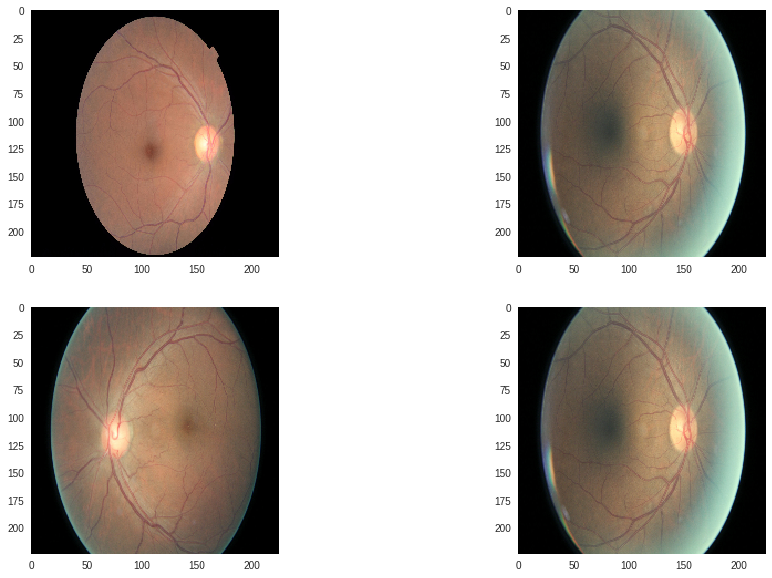

In [96]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.grid'] = False

img1 = utils.load_img('drive/Colab Notebooks/20355_right.jpeg', target_size=(224, 224))
img2 = utils.load_img('drive/Colab Notebooks/20353_left.jpeg', target_size=(224, 224))
img3 = utils.load_img('drive/Colab Notebooks/20346_right.jpeg', target_size=(224, 224))
img4 = utils.load_img('drive/Colab Notebooks/20342_right.jpeg', target_size=(224, 224))

f, ax = plt.subplots(2,2) 
ax[0, 0].imshow(img1)
ax[0, 1].imshow(img2)
ax[1, 0].imshow(img3)
ax[1, 1].imshow(img2)


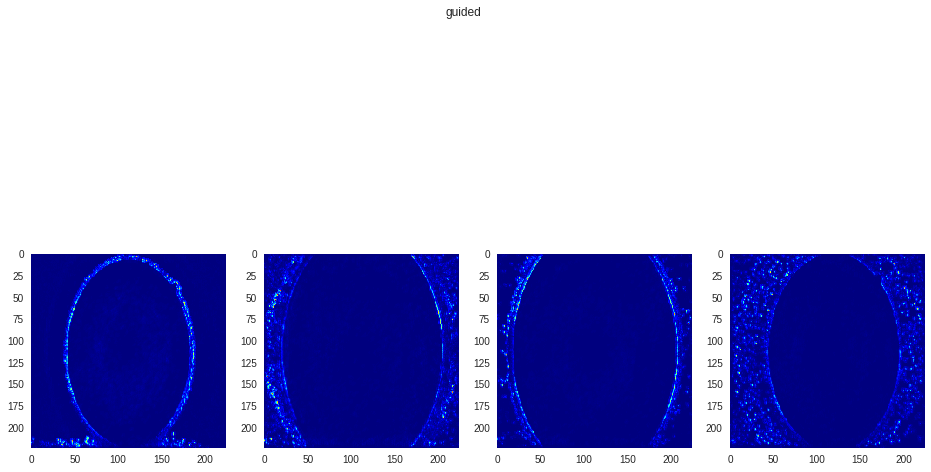

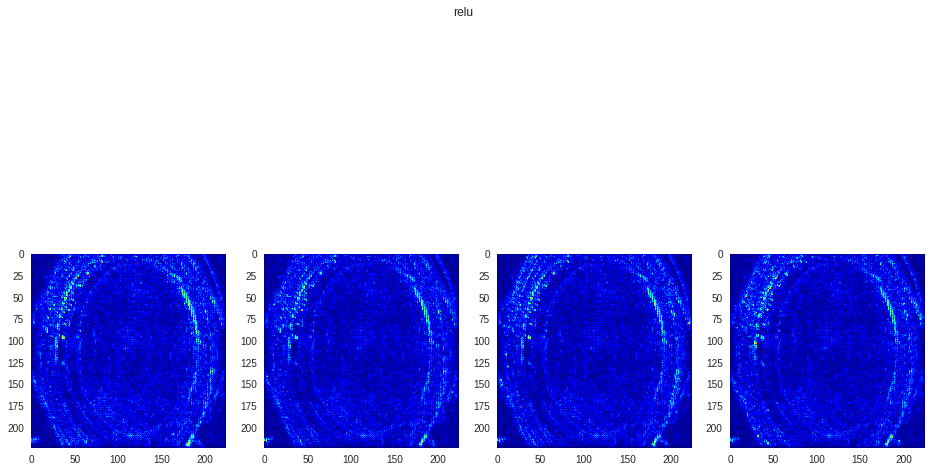

In [97]:
from vis.visualization import visualize_saliency, visualize_activation, visualize_cam


for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2, img3, img4]):    
        grads = visualize_saliency(model, layer_idx, filter_indices=None, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


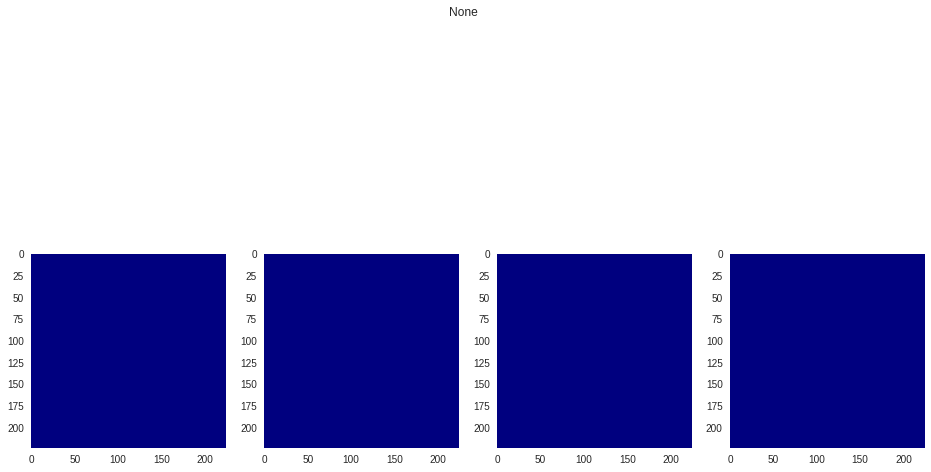

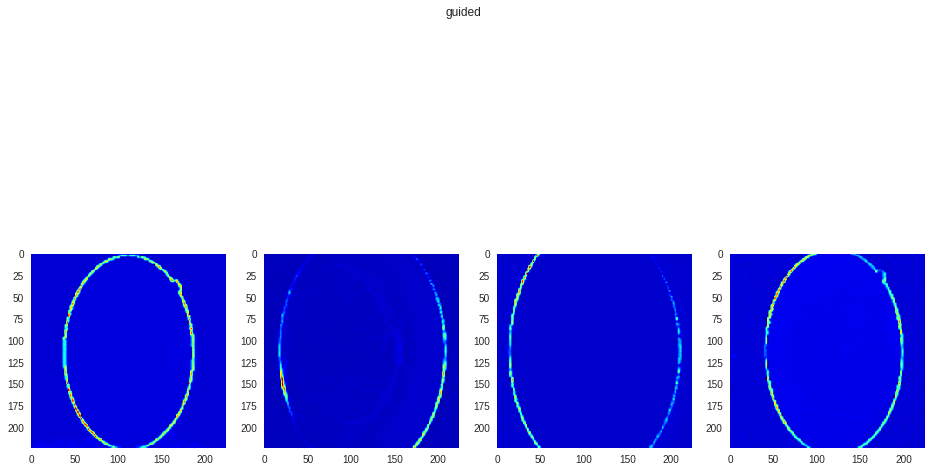

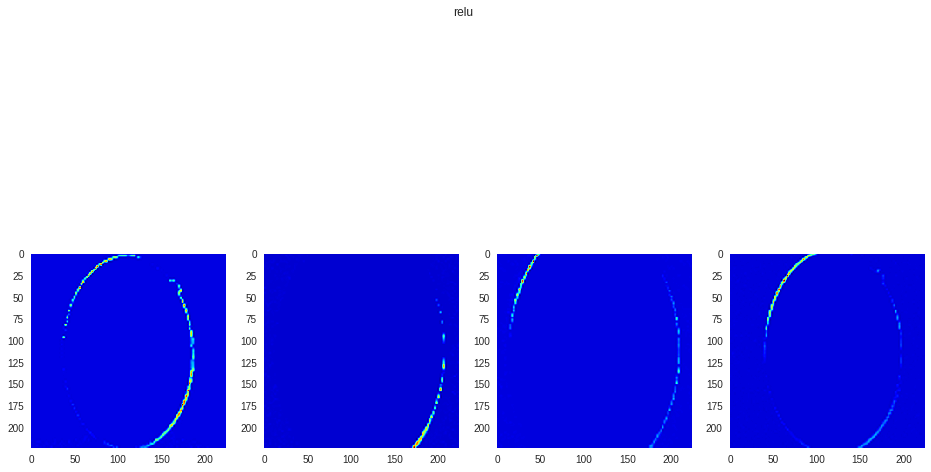

In [98]:
import matplotlib.cm as cm


for grad_modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle(grad_modifier)
    for i, img in enumerate([img1, img2, img3, img4]):    
        grads = visualize_cam(model, layer_idx, filter_indices=None, 
                                   seed_input=img, backprop_modifier=grad_modifier)
        # Lets overlay the heatmap onto original image. 
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(grads, cmap='jet')

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


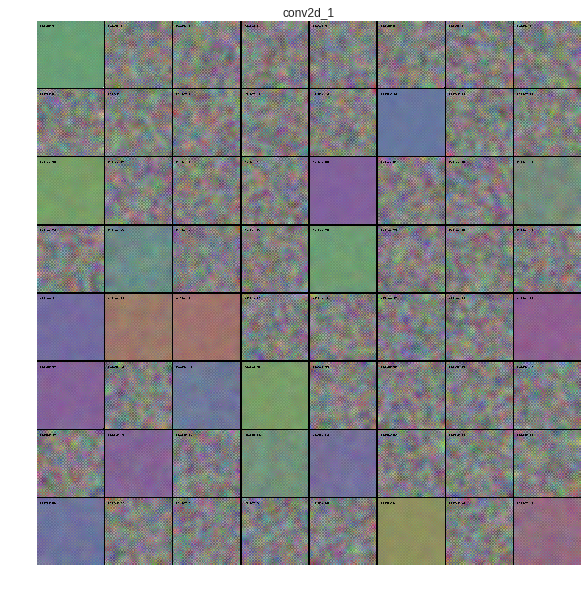

In [101]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv2d_1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

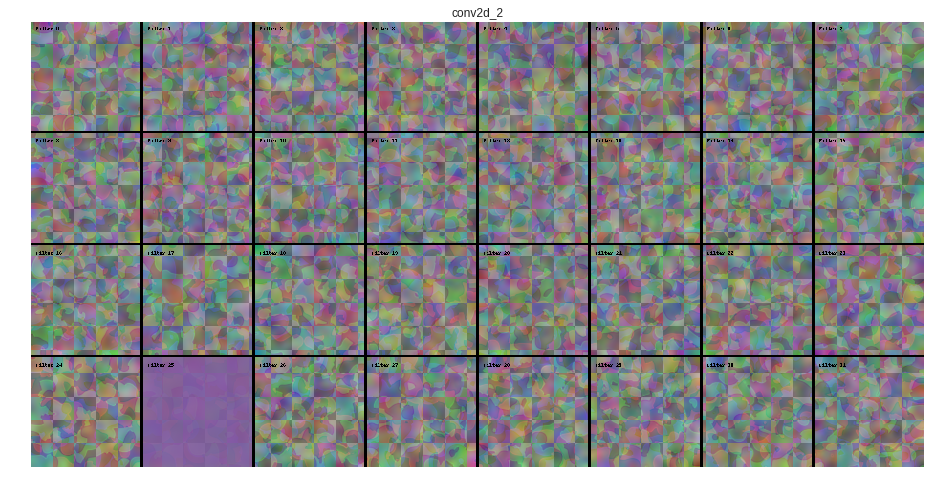

In [103]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv2d_2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

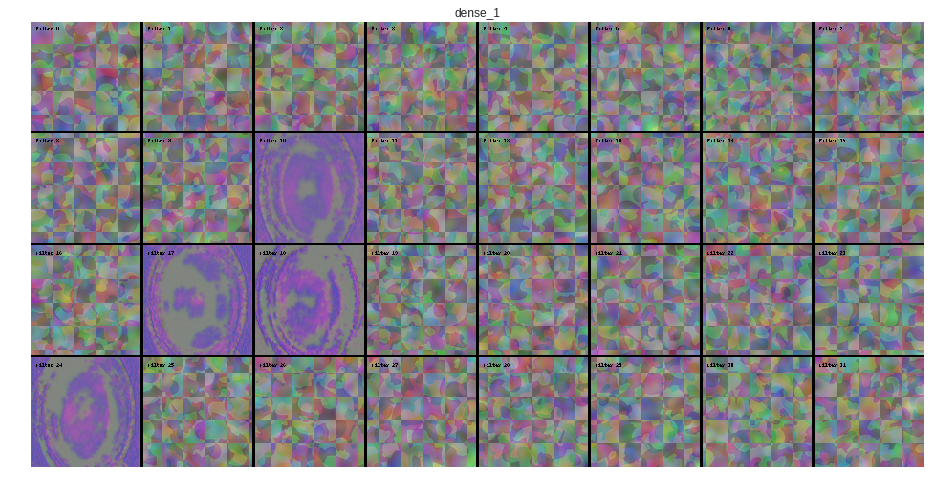

In [104]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'dense_1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


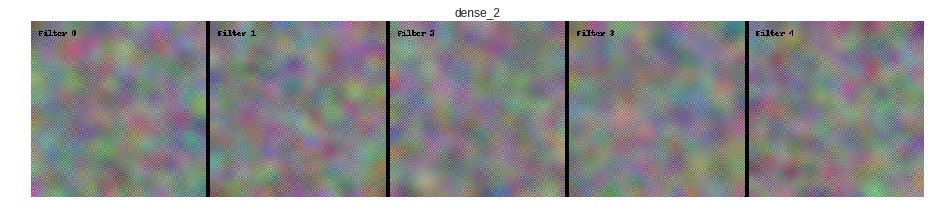

In [102]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'dense_2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

# New Image Classification

In [2]:
from keras.models import load_model

Using TensorFlow backend.


In [6]:
!ls

datalab


In [5]:
model = load_model('drive/Colab\ Notebooks/retinopathy_model.h5')

OSError: ignored

In [0]:
from keras.preprocessing import image

img = image.load_img('drive/Colab Notebooks/41986_right.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = img.reshape((1,) + img.shape)

In [25]:
prediction = model.predict(img)
print("Predicted classes:", prediction)

Predicted classes: [[8.8525265e-21 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [0]:
import pandas as pd
labels = pd.read_csv('drive/Colab Notebooks/labels.csv')

In [45]:
labels.loc[labels['image'] == '41986_right']

image  level
1123  41986_right      2